In [1]:
%load_ext autoreload 
%autoreload 2

In [86]:
!pip install einops

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import os
import einops
import yaml
import shutil

from pprintpp import pprint as pp
from pathlib import Path


In [4]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import CosineAnnealingLR


In [5]:
import models
import utils
# from .test import eval_psnr
from scheduler import GradualWarmupScheduler

from utils import make_coord


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
def count_memory(your_tensor):

    element_size = your_tensor.element_size()  # Size of one element in bytes
    num_elements = your_tensor.numel()  # Total number of elements in the tensor
    memory_usage_bytes = element_size * num_elements  # Total memory usage in bytes

    # Convert to more human-readable formats (e.g., MB or GB)
    memory_usage_mb = memory_usage_bytes / (1024 * 1024)  # Memory usage in MB
    memory_usage_gb = memory_usage_bytes / (1024 * 1024 * 1024)  # Memory usage in GB

    print(f"Memory Usage: {memory_usage_bytes} bytes, {memory_usage_mb:.2f} MB, {memory_usage_gb:.2f} GB")

# Data

In [9]:
input_path = 'data/dataset/'
output_path = "submission/"
checkpoints_dir = Path("checkpoints_final")
checkpoints_dir.exists()

True

## Reading and plotting

In [10]:
#read file ids and file names for train and val data
train_df = pd.read_csv(input_path+'train.csv')
val_df= pd.read_csv(input_path+'val.csv')
#print 5 rows of pandas dataframe
# train_df.head()

In [11]:
def getXY(idx,csv_file,mode = "train"):
    LR_path = input_path + "flowfields/LR/" + mode
    HR_path = input_path + "flowfields/HR/" + mode
    #input
    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16,16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16,16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16,16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16,16)
    #output
    rho_o = np.fromfile(HR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(128,128)
    ux_o = np.fromfile(HR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(128,128)
    uy_o = np.fromfile(HR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(128,128)
    uz_o = np.fromfile(HR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(128,128)
    
    rho_i = torch.from_numpy(rho_i)
    ux_i = torch.from_numpy(ux_i)
    uy_i = torch.from_numpy(uy_i)
    uz_i = torch.from_numpy(uz_i)
    rho_o = torch.from_numpy(rho_o)
    ux_o = torch.from_numpy(ux_o)
    uy_o = torch.from_numpy(uy_o)
    uz_o = torch.from_numpy(uz_o)
    
    X = torch.stack([rho_i,ux_i,uy_i,uz_i],dim=-1)
    Y = torch.stack([rho_o,ux_o,uy_o,uz_o],dim=-1)
    return [X,Y]

def getTrainXY(idx):
    return getXY(idx,train_df.reset_index().to_dict(orient='list'),mode = "train")

def getValXY(idx):
    return getXY(idx,val_df.reset_index().to_dict(orient='list'),mode = "val")

In [12]:
my_mean = [0.24,28.0, 28.0, 28.0]
my_std = [0.068,48.0, 48.0, 48.0]

my_mean = torch.tensor(my_mean)
my_std = torch.tensor(my_std)

In [13]:
def scale_fn(X,Y,my_mean=my_mean,my_std=my_std):
    Xscaled = (X-my_mean)/my_std
    Yscaled = (Y-my_mean)/my_std
    return (Xscaled,Yscaled)

## Dataset

In [14]:
class FlowFieldsDataset(Dataset):
    def __init__(self, csv_file, mode = "train", transform=None, channel_first=False):
        self.csv_file = csv_file
        self.mode = mode
        self.transform = transform
        self.channel_first = channel_first

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        if self.mode == "train":
            X,Y = getTrainXY(idx)
        elif self.mode == "val":
            X,Y = getValXY(idx)
        else:
            print("ERROR: invalid mode")
            return None
        if self.transform:
            X,Y = self.transform(X,Y)
        if self.channel_first:
            X = einops.rearrange(X, "x y c -> c x y")
            Y = einops.rearrange(Y, "x y c -> c x y")
        return X,Y

In [15]:
train_dataset = FlowFieldsDataset(train_df,mode = "train",transform=scale_fn)
val_dataset = FlowFieldsDataset(val_df,mode = "val",transform=scale_fn)

In [16]:
batch_size = 16  # Set your desired batch size
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

## Defining model

In [17]:
global config_edsr, config_rdn, log, writer

config_edsr = "configs/train_edsr-sronet.yaml"
with open(config_edsr, 'r') as f:
    config_edsr = yaml.load(f, Loader=yaml.FullLoader)
    print(f'{config_edsr} loaded.')
    
config_rdn = "configs/train_rdn-sronet.yaml"
with open(config_rdn, 'r') as f:
    config_rdn = yaml.load(f, Loader=yaml.FullLoader)
    print(f'{config_rdn} loaded.')

{'train_dataset': {'dataset': {'name': 'image-folder', 'args': {'root_path': './data/DIV2K_train_HR', 'repeat': 20}}, 'wrapper': {'name': 'sr-implicit-downsampled-fast', 'args': {'inp_size': 128, 'scale_max': 4, 'augment': True}}, 'batch_size': 64}, 'val_dataset': {'dataset': {'name': 'image-folder', 'args': {'root_path': './data/DIV2K_valid_HR'}}, 'wrapper': {'name': 'sr-implicit-downsampled-fast', 'args': {'scale_min': 2, 'scale_max': 2}}, 'batch_size': 1}, 'eval_type': 'div2k-2', 'eval_bsize': 500, 'data_norm': {'inp': {'sub': [0.5], 'div': [0.5]}, 'gt': {'sub': [0.5], 'div': [0.5]}}, 'model': {'name': 'sronet', 'args': {'encoder_spec': {'name': 'edsr-baseline', 'args': {'no_upsampling': True}}, 'width': 256, 'blocks': 16}}, 'optimizer': {'name': 'adam', 'args': {'lr': 4e-05}}, 'epoch_max': 1050, 'warmup_step_lr': {'multiplier': 10, 'total_epoch': 50}, 'epoch_val': 50, 'epoch_save': 250} loaded.
{'train_dataset': {'dataset': {'name': 'image-folder', 'args': {'root_path': './data/DIV

In [18]:
channel_first=True
train_dataset = FlowFieldsDataset(train_df, "train", transform=scale_fn, channel_first=channel_first)  # Assuming you have a train_df
val_dataset = FlowFieldsDataset(val_df, "val", transform=scale_fn, channel_first=channel_first)  # Assuming you have a train_df

for dataset in (train_dataset, val_dataset):
    lr, hr = dataset[0]  # Access the first sample
    print(f"LR: {lr.shape}")
    print(f"HR: {hr.shape}")

LR: torch.Size([4, 16, 16])
HR: torch.Size([4, 128, 128])
LR: torch.Size([4, 16, 16])
HR: torch.Size([4, 128, 128])


In [19]:
class MyAdaptedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __getitem__(self, idx):
        low_resolution, high_resolution = self.original_dataset[idx]
        # Restric to 1st 3 channels
        # low_resolution = low_resolution
        # high_resolution = high_resolution
        
        # compute coord tensor for high_resolution image
        coord = make_coord(high_resolution.shape[-2:], flatten=False) \
            .permute(2, 0, 1) \
            .unsqueeze(0).expand(high_resolution.shape[0], 2, *high_resolution.shape[-2:])
        # Remove channel dim
        coord = coord[0]
        coord = einops.rearrange(coord, "dim_grid x y -> x y dim_grid")
          
        # compute cell tensor
        cell = torch.tensor([2 / high_resolution.shape[-2], 2 / high_resolution.shape[-1]], dtype=torch.float32)
        
        return {'lr': low_resolution, 'hr': high_resolution, 'coord': coord, 'cell': cell}

    def __len__(self):
        return len(self.original_dataset)

In [20]:
train_dataset2 = MyAdaptedDataset(train_dataset)
val_dataset2 = MyAdaptedDataset(val_dataset)
print(len(train_dataset2))
print(len(val_dataset2))

1382
173


In [21]:
def make_data_loader(dataset, batch_size, tag='', ):

    print('{} dataset: size={}'.format(tag, len(dataset)))
    for k, v in dataset[0].items():
        print('  {}: shape={}'.format(k, tuple(v.shape)))

    loader = DataLoader(dataset, batch_size=batch_size,
        shuffle=(tag == 'train'), num_workers=4, pin_memory=True,persistent_workers=True)
    return loader


def make_data_loaders(batch_size):
    train_loader = make_data_loader(train_dataset2, batch_size, tag='train')
    val_loader = make_data_loader(val_dataset2, batch_size, tag='val')
    return train_loader, val_loader

In [22]:
batch_size = 16


### Regenerate the dataloaders

In [58]:
train_loader2, val_loader2 = make_data_loaders(batch_size)


train dataset: size=1382
  lr: shape=(4, 16, 16)
  hr: shape=(4, 128, 128)
  coord: shape=(128, 128, 2)
  cell: shape=(2,)
val dataset: size=173
  lr: shape=(4, 16, 16)
  hr: shape=(4, 128, 128)
  coord: shape=(128, 128, 2)
  cell: shape=(2,)


In [24]:
def prepare_training(encoder='edsr'):
    
    if encoder == 'edsr':
        config = config_edsr
    elif encoder == 'rdn':
        config = config_rdn
    
    if (config.get('resume') is not None) and os.path.exists(config.get('resume')):
        sv_file = torch.load(config['resume'],map_location=torch.device('cpu'))
        print(sv_file['model'])
        model = models.make(sv_file['model'], load_sd=True).to(device)
        optimizer = utils.make_optimizer(
            model.parameters(), sv_file['optimizer'], load_sd=True)
        optimizer.param_groups[0]['lr'] = config['optimizer']['args']['lr']
        epoch_start = sv_file['epoch'] + 1
        if config.get('multi_step_lr') is None:
            cosine = CosineAnnealingLR(optimizer, config['epoch_max']-config['warmup_step_lr']['total_epoch'])
            lr_scheduler = GradualWarmupScheduler(optimizer,**config['warmup_step_lr'],after_scheduler=cosine)
        else:
            lr_scheduler = MultiStepLR(optimizer, **config['multi_step_lr'])
        for e in range(1,epoch_start):
            lr_scheduler.step(e)
            #lr_scheduler.step()
        print(epoch_start,optimizer.param_groups[0]['lr'])
    else:
        model = models.make(config['model']).to(device)
        print(config['model'])
        optimizer = utils.make_optimizer(
            model.parameters(), config['optimizer'])
        epoch_start = 1
        if config.get('multi_step_lr') is None:
            cosine = CosineAnnealingLR(optimizer, config['epoch_max']-config['warmup_step_lr']['total_epoch'])
            lr_scheduler = GradualWarmupScheduler(optimizer,**config['warmup_step_lr'],after_scheduler=cosine)
        else:
            lr_scheduler = MultiStepLR(optimizer, **config['multi_step_lr'])

    print('model: #params={}'.format(utils.compute_num_params(model, text=True)))
    return model, optimizer, epoch_start, lr_scheduler

### Model

In [25]:
model, optimizer, epoch_start, lr_scheduler = prepare_training()


{'name': 'sronet', 'args': {'encoder_spec': {'name': 'edsr-baseline', 'args': {'no_upsampling': True}}, 'width': 256, 'blocks': 16}}
model: #params=2.0M


In [26]:
def val(dataloader, model, \
         epoch, 
       ):
    model.eval()
    loss_fn = nn.L1Loss()
    l2_loss_fn = nn.MSELoss()
    val_loss = utils.Averager()
    l2_val_loss = utils.Averager()
    metric_fn = utils.calc_psnr

    
    iteration = 0
    for batch in dataloader:
        for k, v in batch.items():
            batch[k] = v.cuda(non_blocking=True)

            
        inp = batch["lr"]
        # print(f"coord: {batch['coord'].shape}")
        # print(f"cell: {batch['cell'].shape}")
        pred = model(inp, batch['coord'], batch['cell'])

        gt = batch["hr"]
        loss = loss_fn(pred, gt)
        l2_loss = l2_loss_fn(pred, gt)
        #psnr = metric_fn(pred, gt)
        
        iteration += 1
        
        val_loss.add(loss.item())
        l2_val_loss.add(l2_loss.item())

        pred = None; loss = None
        
    return val_loss.item(), l2_val_loss.item()

## Functions for predicting

In [27]:
coord = train_dataset2[0]["coord"]
cell = train_dataset2[0]["cell"]
print(coord.shape)
print(cell.shape)
coord = coord.unsqueeze(0)
cell = cell.unsqueeze(0)
print(coord.shape)
print(cell.shape)

torch.Size([128, 128, 2])
torch.Size([2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 2])


In [28]:
my_mean_reshaped = my_mean.reshape(1, 4, 1, 1)
my_std_reshaped = my_std.reshape(1, 4, 1, 1)

In [29]:
def getTestX(idx,):
    csv_file = test_df.reset_index().to_dict(orient='list')
    LR_path = input_path + "flowfields/LR/test"
    id = csv_file['id'][idx]

    rho_i = np.fromfile(LR_path + "/" + csv_file['rho_filename'][idx], dtype="<f4").reshape(16, 16)
    ux_i = np.fromfile(LR_path + "/" + csv_file['ux_filename'][idx], dtype="<f4").reshape(16, 16)
    uy_i = np.fromfile(LR_path + "/" + csv_file['uy_filename'][idx], dtype="<f4").reshape(16, 16)
    uz_i = np.fromfile(LR_path + "/" + csv_file['uz_filename'][idx], dtype="<f4").reshape(16, 16)

    X = torch.stack([torch.from_numpy(rho_i), torch.from_numpy(ux_i), torch.from_numpy(uy_i), torch.from_numpy(uz_i)], axis=2)
    return id, X

In [30]:
def predict(idx, model, my_mean, my_std, coord, cell):
    print(f"idx: {idx}")
    id, X = getTestX(idx)  # Assuming you have a getTestX function as defined previously
    X = torch.unsqueeze(X.clone().detach(), 0)  # Add a batch dimension: (b, x, y, c)
    X, _ = scale_fn(X, X)
    X = einops.rearrange(X, "b x y c -> b c x y")

    # X = (X - torch.tensor(my_mean)) / torch.tensor(my_std)  # Scale the input data
    
    model.eval()
    
    y_pred = model(X.to(device), coord.to(device), cell.to(device)).detach()
    
    # Rescale predictions (assuming my_std and my_mean are tensors)
    y_pred_unscaled = (y_pred.clone().detach().cpu() * my_std.reshape(1, -1, 1, 1) + my_mean.reshape(1, -1, 1, 1) )

    return id, y_pred, y_pred_unscaled

In [31]:
def generate_submission(model, test_df, my_mean, my_std, coord, cell):
    y_preds = {}
    y_preds_unscaled = {}
    ids = []
    
    model.eval()
    
    my_mean = [0.24,28.0, 28.0, 28.0]
    my_std = [0.068,48.0, 48.0, 48.0]
    my_mean = np.array(my_mean)
    my_std = np.array(my_std)
    
    with torch.no_grad():
        for idx in range(len(test_df)):
            id, y_pred, y_pred_unscaled = predict(idx, model, my_mean, my_std, coord, cell)  # Assuming you have a predict function as defined previously
            
            y_pred = y_pred[0]
            y_pred = einops.rearrange(y_pred, "c x y -> x y c")
            tmp = (np.array(y_pred.cpu()) - my_mean)/my_std #this normalizes density and velocity to be in the same range

            y_preds[id] = np.array(tmp).flatten(order='C').astype(np.float32)
            y_preds_unscaled[id] = np.array(y_pred.clone().detach().cpu()).flatten(order='C').astype(np.float32)
            ids.append(id)

    df = pd.DataFrame.from_dict(y_preds, orient='index')
    df['id'] = ids

    # Move 'id' to the first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]

    # Reset index
    df = df.reset_index(drop=True)

    df_unscaled = pd.DataFrame.from_dict(y_preds_unscaled, orient='index')
    df_unscaled['id'] = ids

    # Move 'id' to the first column
    cols = df_unscaled.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_unscaled = df_unscaled[cols]

    # Reset index
    df_unscaled = df_unscaled.reset_index(drop=True)

    return df, df_unscaled

## Ensembling multiple models

In [32]:
class ModelAveraging(nn.Module):
    def __init__(self, models):
        super(ModelAveraging, self).__init__()
        self.models = nn.ModuleList(models)
        
    def forward(self, *x):
        predictions = [model(*x) for model in self.models]
        # Element-wise average of predictions
        avg_prediction = torch.mean(torch.stack(predictions), dim=0)
        return avg_prediction

### Loading selected Checkpoints

In [33]:
def get_checkpoints_paths_from_ids(checkpoints_ids, checkpoints_dir):
    best_checkpoints_paths_list = [f'{str(checkpoints_dir)}' + '/' + f'best_model_checkpoint_{id}.pth' for id in checkpoints_ids]
    return best_checkpoints_paths_list

In [34]:
top_k_ids = ['vxyhe45d', 'k8hvy0gk', '1kmzdxt5', '3hlpjwq2', 'w9zjrnci', '0favun8v', 'zlivwght', 'fb21xihf', 'iwhi66ge', 'vb4rnyj2', 'au9sychs', 'c3g13clp', '6x90654h', '7i3nue7m', 'it1viwdv', 'gq3xir5p', '4qt0vpt2', 'i284od6o', 'yfc494bo', 'dgqlq15o', '4mxzam3j', '2e6khwke', 'i7w4lmer', 'w0p78a9u', 'az6aek4r', 'cdcepx92', 'a3ts28vy', 'g8vke5ap', 'vps855hr', 'ndqdpgut', '6wtep94v', 'z3y0z0u3', 'q0mz0aa3', '260j81sg', 'w3ywkpcz']

In [35]:
top_k_paths = get_checkpoints_paths_from_ids(top_k_ids, checkpoints_dir)
new_best_checkpoint_path_list = top_k_paths

In [36]:
len(new_best_checkpoint_path_list)

35

In [37]:
pp(new_best_checkpoint_path_list)

[
    'checkpoints_final/best_model_checkpoint_vxyhe45d.pth',
    'checkpoints_final/best_model_checkpoint_k8hvy0gk.pth',
    'checkpoints_final/best_model_checkpoint_1kmzdxt5.pth',
    'checkpoints_final/best_model_checkpoint_3hlpjwq2.pth',
    'checkpoints_final/best_model_checkpoint_w9zjrnci.pth',
    'checkpoints_final/best_model_checkpoint_0favun8v.pth',
    'checkpoints_final/best_model_checkpoint_zlivwght.pth',
    'checkpoints_final/best_model_checkpoint_fb21xihf.pth',
    'checkpoints_final/best_model_checkpoint_iwhi66ge.pth',
    'checkpoints_final/best_model_checkpoint_vb4rnyj2.pth',
    'checkpoints_final/best_model_checkpoint_au9sychs.pth',
    'checkpoints_final/best_model_checkpoint_c3g13clp.pth',
    'checkpoints_final/best_model_checkpoint_6x90654h.pth',
    'checkpoints_final/best_model_checkpoint_7i3nue7m.pth',
    'checkpoints_final/best_model_checkpoint_it1viwdv.pth',
    'checkpoints_final/best_model_checkpoint_gq3xir5p.pth',
    'checkpoints_final/best_model_chec

In [38]:
def get_model_from_checkpoint_path(best_checkpoint_path):
    if os.path.exists(best_checkpoint_path):
        
        # Load the checkpoint
        checkpoint = torch.load(best_checkpoint_path)
        
        # Create a new instance of the model
        case1_failed = False
        case2_failed = False
        try:
            model, _, _, _ = prepare_training(encoder='edsr')
            # Load model and optimizer state
            model.load_state_dict(checkpoint['model_state_dict'])
        except Exception as e1:
            case1_failed = True
        
            try:
                model, _, _, _ = prepare_training(encoder='rdn')
                # Load model and optimizer state
                model.load_state_dict(checkpoint['model_state_dict'])
            except Exception as e2:
                case2_failed = True
            
        if case1_failed and case2_failed:
            # Handle the exceptions or raise a new exception here
            print("All cases failed")

        
        return model
    else:
        print(f"Checkpoint not found at: {best_checkpoint_path}")
        return None

⚠️ These prints seem to be for model creation, but do not reflect the succesful (or not) loading of the checkpoint  
Hence, it returns 2x lines for each successful checkpoint loading

In [39]:
models_list = [get_model_from_checkpoint_path(best_checkpoint_path) for best_checkpoint_path in new_best_checkpoint_path_list]
print(len(models_list))

{'name': 'sronet', 'args': {'encoder_spec': {'name': 'edsr-baseline', 'args': {'no_upsampling': True}}, 'width': 256, 'blocks': 16}}
model: #params=2.0M
{'name': 'sronet', 'args': {'encoder_spec': {'name': 'rdn', 'args': {'no_upsampling': True}}, 'width': 256, 'blocks': 16}}
model: #params=22.8M
{'name': 'sronet', 'args': {'encoder_spec': {'name': 'edsr-baseline', 'args': {'no_upsampling': True}}, 'width': 256, 'blocks': 16}}
model: #params=2.0M
{'name': 'sronet', 'args': {'encoder_spec': {'name': 'rdn', 'args': {'no_upsampling': True}}, 'width': 256, 'blocks': 16}}
model: #params=22.8M
{'name': 'sronet', 'args': {'encoder_spec': {'name': 'edsr-baseline', 'args': {'no_upsampling': True}}, 'width': 256, 'blocks': 16}}
model: #params=2.0M
{'name': 'sronet', 'args': {'encoder_spec': {'name': 'rdn', 'args': {'no_upsampling': True}}, 'width': 256, 'blocks': 16}}
model: #params=22.8M
{'name': 'sronet', 'args': {'encoder_spec': {'name': 'edsr-baseline', 'args': {'no_upsampling': True}}, 'widt

In [40]:
len(models_list)

35

### Model definition: Averaged Model

In [41]:
model_averaged = ModelAveraging(models_list)

### Generate the submission

#### DataFrame

In [46]:
coord = train_dataset2[0]["coord"]
cell = train_dataset2[0]["cell"]
print(coord.shape)
print(cell.shape)
coord = coord.unsqueeze(0)
cell = cell.unsqueeze(0)
print(coord.shape)
print(cell.shape)

torch.Size([128, 128, 2])
torch.Size([2])
torch.Size([1, 128, 128, 2])
torch.Size([1, 2])


In [47]:
test_df = pd.read_csv(input_path+'/test.csv')
submission_df, submission_df_unscaled = generate_submission(model_averaged, test_df, my_mean_reshaped.to(device), my_std_reshaped.to(device), coord, cell)

idx: 0
idx: 1
idx: 2
idx: 3
idx: 4
idx: 5
idx: 6
idx: 7
idx: 8
idx: 9
idx: 10
idx: 11
idx: 12
idx: 13
idx: 14
idx: 15
idx: 16
idx: 17
idx: 18
idx: 19
idx: 20
idx: 21
idx: 22
idx: 23
idx: 24
idx: 25
idx: 26
idx: 27
idx: 28
idx: 29
idx: 30
idx: 31
idx: 32
idx: 33
idx: 34
idx: 35
idx: 36
idx: 37
idx: 38
idx: 39
idx: 40
idx: 41
idx: 42
idx: 43
idx: 44
idx: 45
idx: 46
idx: 47
idx: 48
idx: 49
idx: 50
idx: 51
idx: 52
idx: 53
idx: 54
idx: 55
idx: 56
idx: 57
idx: 58
idx: 59
idx: 60
idx: 61
idx: 62
idx: 63
idx: 64
idx: 65
idx: 66
idx: 67
idx: 68
idx: 69
idx: 70
idx: 71
idx: 72
idx: 73
idx: 74
idx: 75
idx: 76
idx: 77
idx: 78
idx: 79
idx: 80
idx: 81
idx: 82
idx: 83
idx: 84
idx: 85
idx: 86
idx: 87
idx: 88
idx: 89
idx: 90
idx: 91
idx: 92
idx: 93
idx: 94
idx: 95
idx: 96
idx: 97
idx: 98
idx: 99
idx: 100
idx: 101
idx: 102
idx: 103
idx: 104
idx: 105
idx: 106
idx: 107
idx: 108
idx: 109
idx: 110
idx: 111
idx: 112
idx: 113
idx: 114
idx: 115
idx: 116
idx: 117
idx: 118
idx: 119
idx: 120
idx: 121
idx: 122
idx

#### CSV

In [48]:
print(submission_df_unscaled.shape)
submission_df_unscaled.head()

(173, 65537)


id         0         1         2         3         4  \
0  -657116647631363807  0.976474  0.965286 -0.542311 -0.569769  0.976448   
1  7483162365939134796  0.976041  0.632742 -0.580253 -0.585093  0.975995   
2 -6212758420087317096  0.976107  0.659986 -0.585500 -0.581143  0.976051   
3 -1825935182480952214 -0.890211  1.372898 -0.522985 -1.133716 -0.890519   
4 -1859240836295259171  2.519195 -0.543395 -0.556139 -0.583219  2.519292   

          5         6         7         8  ...     65526     65527     65528  \
0  0.963843 -0.542423 -0.569726  0.976420  ... -0.605479 -0.599789  0.975287   
1  0.652261 -0.579953 -0.584101  0.975968  ... -0.419495 -0.563209  0.975741   
2  0.664676 -0.585185 -0.581150  0.976006  ... -0.571731 -0.573970  0.976260   
3  1.358962 -0.512413 -1.110296 -0.891067  ... -0.924681 -1.526661 -0.902818   
4 -0.544063 -0.556234 -0.583026  2.519380  ... -0.352087 -0.765053  0.867363   

      65529     65530     65531     65532     65533     65534     65535  
0  0.937918 -0.605812 -0.599672  0.974958  0.945455 -0.605951 -0.599763  
1  0.292461 -0.402306 -0.571178  0.975776  0.316973 -0.383343 -0.580007  
2  0.862448 -0.571896 -0.574361  0.976212  0.846221 -0.572194 -0.574909  
3  1.814503 -0.998191 -1.521132 -0.903091  1.776753 -1.057261 -1.504108  
4 -0.336067 -0.349519 -0.767479  0.818014 -0.332193 -0.347364 -0.769682  

[5 rows x 65537 columns]

In [49]:
print(output_path)

submission/


In [50]:
if not os.path.exists(output_path):
    # If it doesn't exist, create it
    os.makedirs(output_path)
    print(f"Folder '{output_path}' created.")
else:
    print(f"Folder '{output_path}' already exists.")

Folder 'submission/' already exists.


In [51]:
n_ensemble = len(models_list)
n_ensemble

35

In [52]:
from datetime import datetime
today = datetime.today()
formatted_date = today.strftime("%Y_%m_%d_%H_%M")
print(formatted_date)

2023_09_15_20_42


In [53]:
output_filename = f"{formatted_date}_submission_ensemble_of_top_{n_ensemble}" + ".csv"

output_filepath = output_path + output_filename
print(output_filepath)

submission/2023_09_15_20_42_submission_ensemble_of_top_35.csv


In [54]:
# submission_df.to_csv(output_path+'submission.csv',index=False)
submission_df_unscaled.to_csv(output_path+output_filename,index=False)

---

## Computing losses

In [82]:
batch_size_inference = 64  # 256 TOO much for 48 Gb RAM
train_loader_inference, val_loader_inference = make_data_loaders(batch_size_inference)


train dataset: size=1382
  lr: shape=(4, 16, 16)
  hr: shape=(4, 128, 128)
  coord: shape=(128, 128, 2)
  cell: shape=(2,)
val dataset: size=173
  lr: shape=(4, 16, 16)
  hr: shape=(4, 128, 128)
  coord: shape=(128, 128, 2)
  cell: shape=(2,)


In [83]:
with torch.no_grad():
    train_loss, l2_train = val(train_loader_inference, model_averaged, 9999)
    val_loss, l2_val = val(val_loader_inference, model_averaged, 9999)
print('train_loss: ', train_loss, 'l2_train: ', l2_train)
print('val_loss: ', val_loss, 'l2_val: ', l2_val)

train_loss:  0.003122261492535472 l2_train:  8.088720212320119e-05
val_loss:  0.028079307327667873 l2_val:  0.0046181172753373785


## Plotting model predictions

In [78]:
train_loader2, val_loader2 = make_data_loaders(batch_size)


train dataset: size=1382
  lr: shape=(4, 16, 16)
  hr: shape=(4, 128, 128)
  coord: shape=(128, 128, 2)
  cell: shape=(2,)
val dataset: size=173
  lr: shape=(4, 16, 16)
  hr: shape=(4, 128, 128)
  coord: shape=(128, 128, 2)
  cell: shape=(2,)


In [92]:
def plot_samples_ensemble(dataloader, model, n_samples=2, n_models_to_plot=5, figsize=(10, 7)):
    model.eval()
    for batch in dataloader:
        # print(batch)
        # print(len(batch))
        for k, v in batch.items():
            batch[k] = v.cuda(non_blocking=True)


        inp = batch["lr"]
        # print(f"coord: {batch['coord'].shape}")
        # print(f"cell: {batch['cell'].shape}")
        with torch.no_grad():
            pred = model(inp, batch['coord'], batch['cell'])

        gt = batch["hr"]
        
        print("Order of plots by row: Source - GT - Pred by Ensemble model - Preds by individual models")
        for i in range(n_samples):
            print(f"Sample n° {i}")
            lr = inp[i:i+1]
            hr = gt[i:i+1]
            hr_pred = pred[i:i+1].detach()
            
            fig, axs = plt.subplots(3, 4, figsize=figsize)
            min_values = [0]*4
            max_values = [0]*4
            for c in range(4):
                # Compute min and max values for this color channel across all samples
                min_values[c] = min(lr[:, c, :, :].min(), hr[:, c, :, :].min(), hr_pred[:, c, :, :].min())
                max_values[c] = max(lr[:, c, :, :].max(), hr[:, c, :, :].max(), hr_pred[:, c, :, :].max())
                
                # Plotting Source low-resolution image
                axs[0, c].imshow(lr[:, c, :, :].cpu().numpy().reshape(16, 16), cmap='jet', vmin=min_values[c], vmax=max_values[c])
                # Plotting Target high-resolution image
                axs[1, c].imshow(hr[:, c, :, :].cpu().numpy().reshape(128, 128), cmap='jet', vmin=min_values[c], vmax=max_values[c])
                # Plotting Model prediction high-resolution image
                axs[2, c].imshow(hr_pred[:, c, :, :].cpu().numpy().reshape(128, 128), cmap='jet', vmin=min_values[c], vmax=max_values[c])
            
            # Plotting individual models' predictions high-resolution images
            for mod in model_averaged.models[:n_models_to_plot]:
                with torch.no_grad():
                    pred_mod = mod(inp, batch['coord'], batch['cell'])
                    fig, axs = plt.subplots(1, 4, figsize=figsize)
                    for c in range(4):
                        hr_pred_mod = pred_mod[i:i+1].detach()
                        # print(torch.mean(hr_pred_mod))
                        axs[c].imshow(hr_pred_mod[:, c, :, :].cpu().numpy().reshape(128, 128), cmap='jet', vmin=min_values[c], vmax=max_values[c])
            plt.show()
            plt.close()

        break


### On Train

Order of plots by row: Source - GT - Pred by Ensemble model - Preds by individual models
Sample n° 0


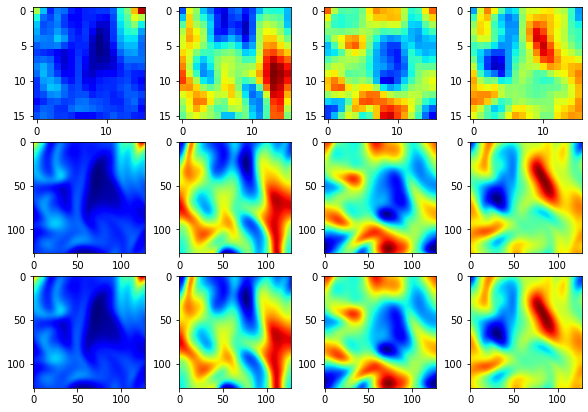

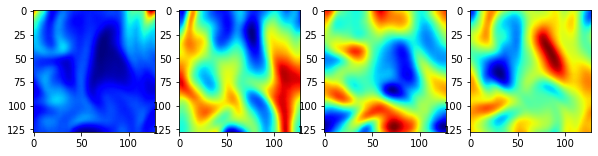

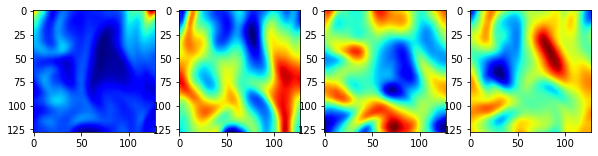

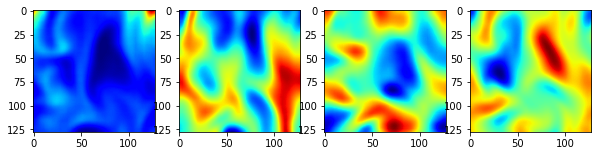

Sample n° 1


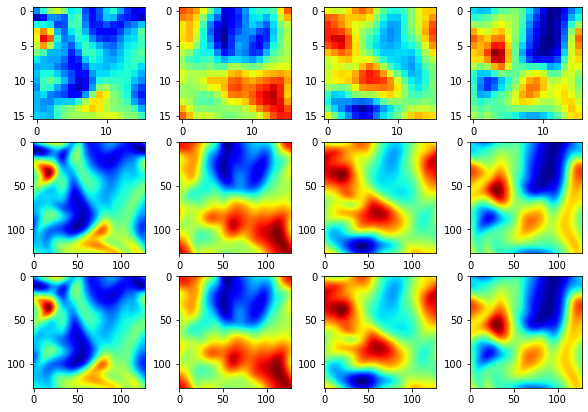

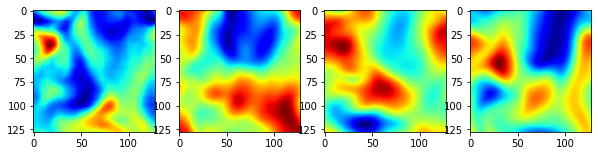

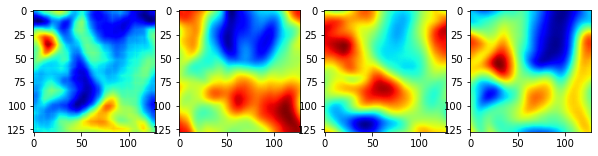

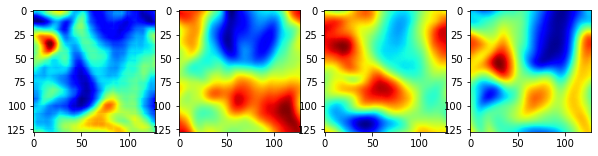

Sample n° 2


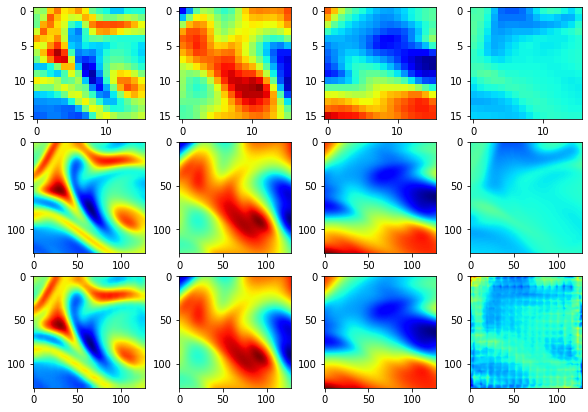

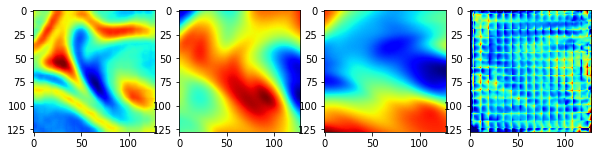

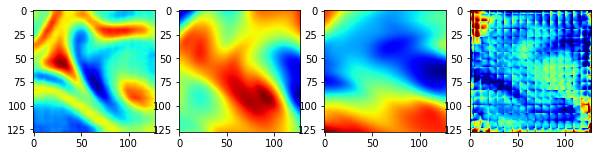

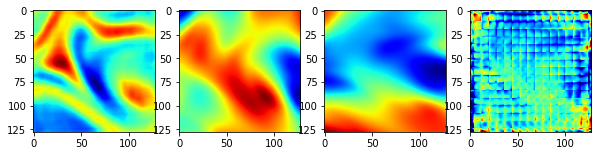

Sample n° 3


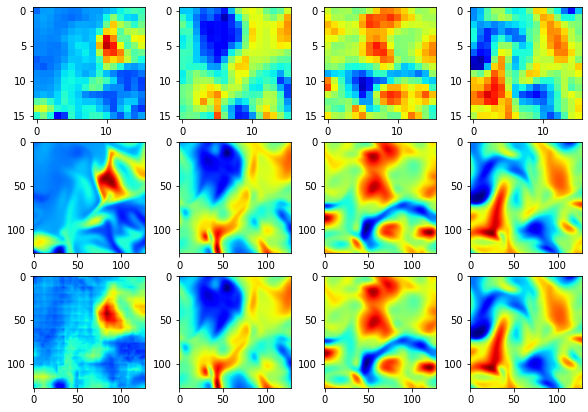

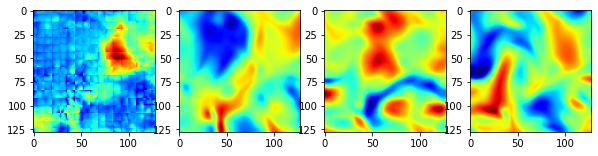

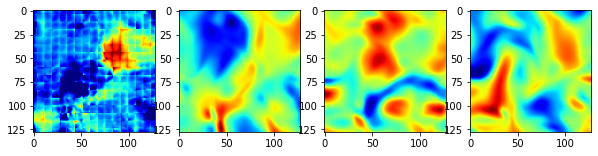

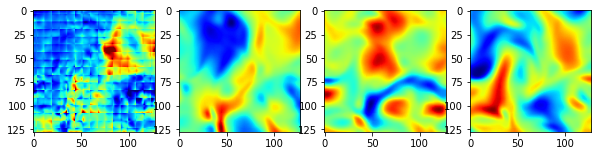

Sample n° 4


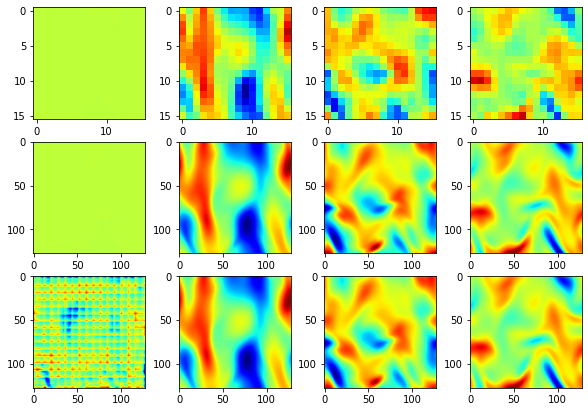

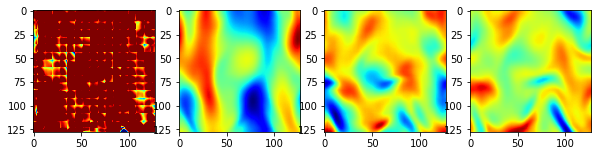

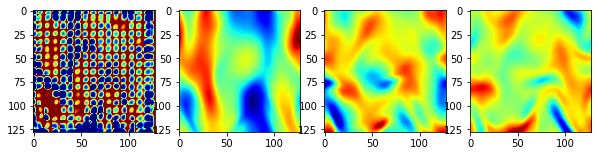

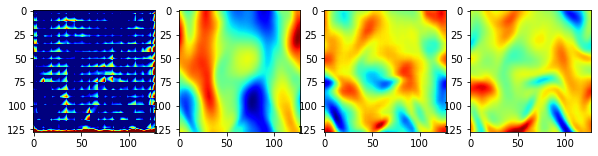

In [95]:
plot_samples_ensemble(train_loader2, model_averaged, n_samples=5, n_models_to_plot=3)

### On Val

Order of plots by row: Source - GT - Pred by Ensemble model - Preds by individual models
Sample n° 0


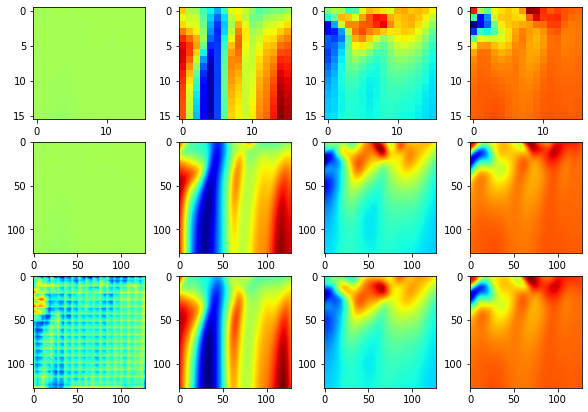

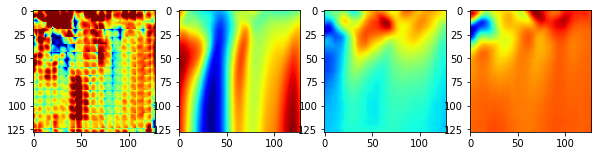

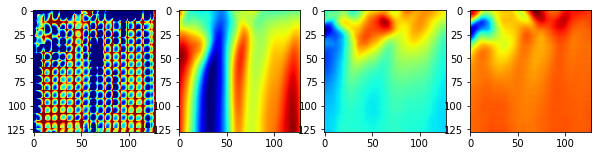

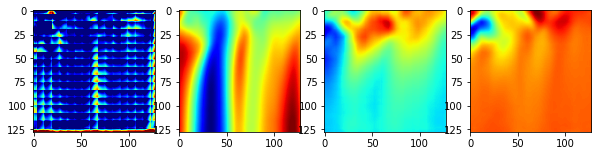

Sample n° 1


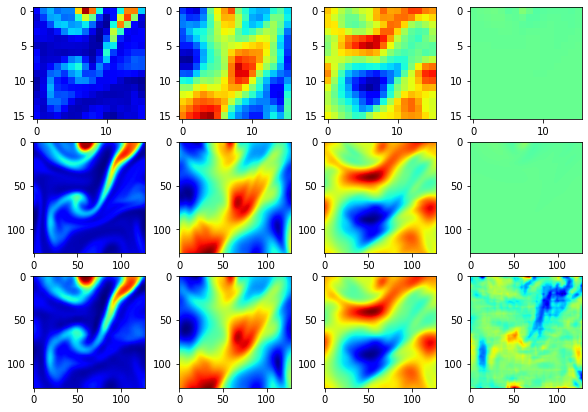

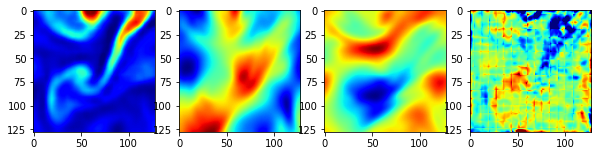

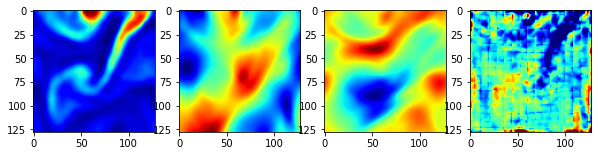

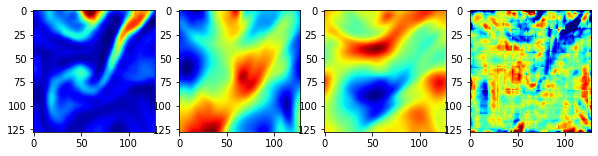

Sample n° 2


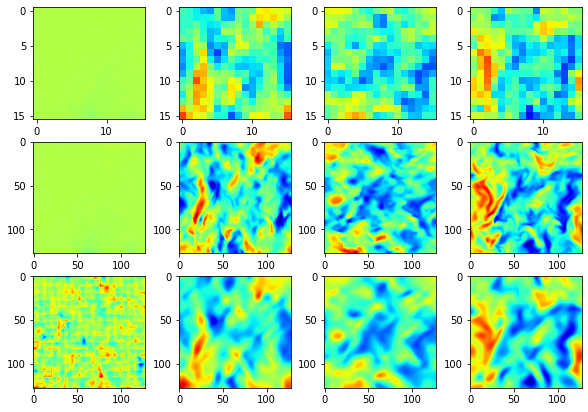

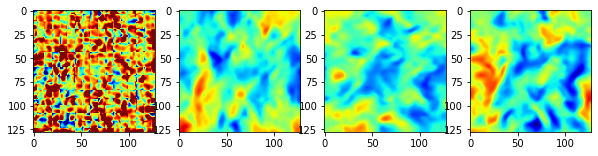

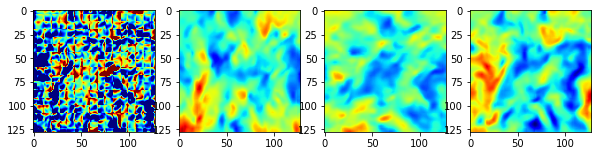

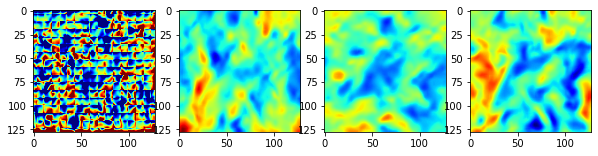

Sample n° 3


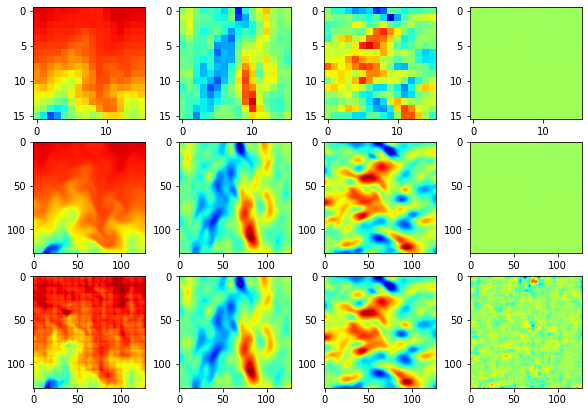

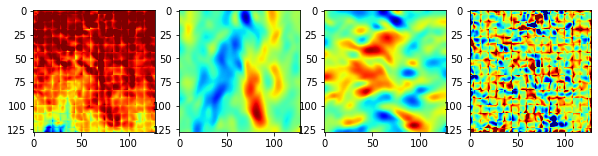

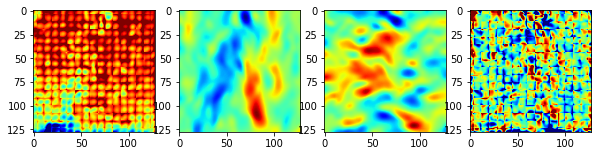

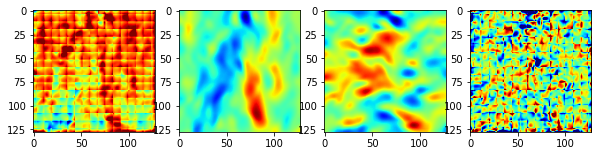

Sample n° 4


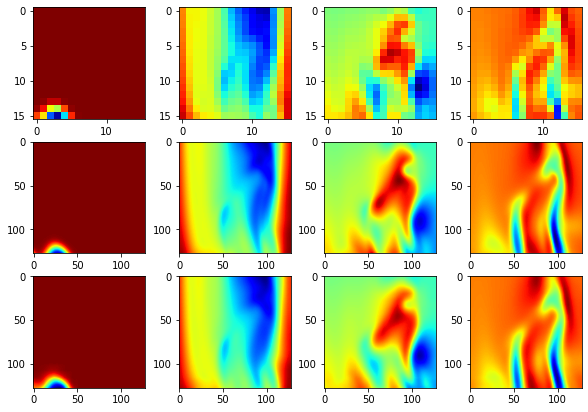

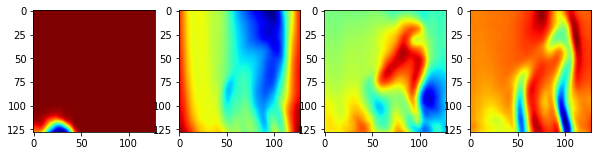

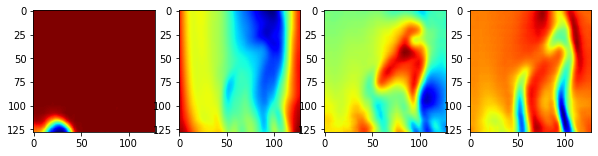

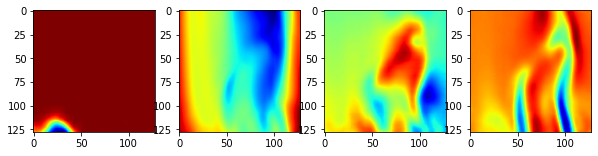

In [96]:
plot_samples_ensemble(val_loader2, model_averaged, n_samples=5, n_models_to_plot=3)